### kedro catalogs

In [1]:
%load_ext kedro.extras.extensions.ipython

The kedro.extras.extensions.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.extras.extensions.ipython


In [2]:
%reload_kedro

2022-07-20 09:11:16,569 - kedro.framework.hooks.manager - INFO - Registered hooks from 1 installed plugin(s): kedro-mlflow-0.8.1
2022-07-20 09:11:16,618 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-07-20 09:11:17,260 - root - INFO - ** Kedro project GetInData ML Framework
2022-07-20 09:11:17,260 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-07-20 09:11:17,270 - root - INFO - Registered line magic `run_viz`
2022-07-20 09:11:17,271 - root - INFO - Registered line magic `reload_kedro_mlflow`


In [3]:
catalog.list()

['articles',
 'customers',
 'transactions',
 'customers_sample',
 'transactions_sample',
 'image_embeddings',
 'parameters',
 'params:image_embeddings_inference',
 'params:image_embeddings_inference.RUN_ID',
 'params:image_embeddings_inference.image_path',
 'params:image_embeddings_inference.batch_size',
 'params:image_embeddings',
 'params:image_embeddings.image_path',
 'params:image_embeddings.encoder',
 'params:image_embeddings.decoder',
 'params:image_embeddings.batch_size',
 'params:image_embeddings.image_size',
 'params:image_embeddings.embedding_size',
 'params:image_embeddings.num_epochs',
 'params:image_embeddings.save_model',
 'params:image_embeddings.model_name',
 'params:cutoff_date',
 'params:sample_size']

### loading data

In [4]:
embeddings = context.catalog.load('image_embeddings')

2022-07-20 09:11:17,295 - kedro.io.data_catalog - INFO - Loading data from `image_embeddings` (ParquetDataSet)...


In [5]:
articles = context.catalog.load('articles')

2022-07-20 09:11:17,342 - kedro.io.data_catalog - INFO - Loading data from `articles` (CSVDataSet)...


In [6]:
embeddings

,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,...,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32
0520567001,1.113570,1.652965,-2.150664,2.089924,1.185918,2.260038,0.347188,2.013080,-4.734544,2.401829,...,2.000686,-0.203081,-2.842822,0.491076,-0.041898,2.544570,0.108711,1.582202,4.200385,-2.020447
0878510001,1.440896,1.386671,-2.282617,2.140737,0.861950,2.160086,0.081075,1.767792,-4.800898,1.992157,...,1.690953,-0.155355,-3.091208,0.587815,-0.451221,2.764887,0.472128,1.551016,4.164678,-2.076929
0573864007,-0.756773,1.515813,-0.575650,0.610912,1.729891,1.219589,1.066304,1.665391,-1.978382,2.578543,...,1.910696,-0.529836,-0.362874,-0.167186,1.493992,0.243355,-1.165456,1.051262,2.017650,-0.793614
0832893002,1.166671,1.358555,-2.204620,1.964761,1.020163,2.024498,0.176020,1.753473,-4.681295,2.140842,...,1.751043,-0.385466,-2.843528,0.478610,-0.180656,2.487392,0.343982,1.669561,4.088965,-2.068283
0654410024,0.954770,1.656038,-1.991702,1.965235,1.226131,2.180871,0.416728,1.989732,-4.460274,2.408420,...,1.992496,-0.192630,-2.616585,0.438648,0.085421,2.344975,-0.017950,1.501997,3.983208,-1.887907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0633529002,1.327523,1.419485,-2.195643,2.077033,0.920927,2.135106,0.145037,1.786679,-4.670393,2.046457,...,1.725392,-0.160069,-2.958032,0.551450,-0.341934,2.646330,0.370856,1.521311,4.072208,-2.011706
0822895002,0.465804,1.816446,-1.594110,1.694565,1.478174,2.086462,0.703057,2.081953,-3.864438,2.640220,...,2.145513,-0.175431,-2.029728,0.285484,0.555910,1.832350,-0.474977,1.341418,3.559664,-1.581277
0759602003,0.219211,1.449860,-1.859456,1.441603,1.624016,1.712479,0.602240,1.854158,-4.219372,2.756952,...,2.081357,-0.978436,-1.977928,0.126406,0.792343,1.577121,-0.248939,1.944524,3.823016,-1.952026
0808866004,1.321241,1.388883,-2.257353,2.074804,0.943261,2.115245,0.129432,1.777275,-4.772482,2.077286,...,1.734248,-0.257146,-2.993631,0.540961,-0.325650,2.653567,0.409768,1.610972,4.155088,-2.082841


In [7]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


### show similar articles

There is also `torch.cdist` for calculating distances between vectors, if you want to do these calculations in PyTorch

In [8]:
from sklearn.neighbors import KDTree
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd

In [9]:
os.getcwd()

'/Users/mmadej/Desktop/Projects/gid-ml-framework/notebooks'

In [10]:
os.chdir('../data/01_raw/images_128_128')

In [11]:
os.getcwd()

'/Users/mmadej/Desktop/Projects/gid-ml-framework/data/01_raw/images_128_128'

In [12]:
tree = KDTree(embeddings.values, leaf_size=5)

In [13]:
def find_similar_images(query_article_id, embeddings, tree):
    _, ind = tree.query(embeddings.loc[query_article_id].values.reshape(1, -1), k=5)
    closest_embeddings = embeddings.iloc[ind[0]].index.tolist()
    imgs = [Image.open(f'{article_id}.jpg').convert('RGB') for article_id in closest_embeddings]
    _, axs = plt.subplots(1, 5, figsize=(12, 12))
    axs = axs.flatten()
    for img, article_id, ax in zip(imgs, closest_embeddings, axs):
        ax.title.set_text(f'{article_id}')
        ax.imshow(img)
    plt.show()

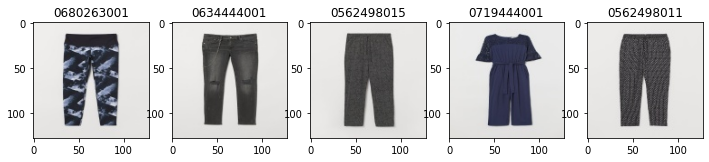

In [14]:
find_similar_images('0680263001', embeddings, tree)

In [15]:
def plot_n_random_similar_images(n, articles):
    for i in range(n):
        random_article = articles.sample(1)
        print(f'''{i+1} random article:
        {random_article.prod_name},
        {random_article.article_id},
        {random_article.product_group_name}
        ''')
        find_similar_images(random_article.article_id, embeddings, tree)
        print('\n\n\n')

1 random article:
        4529    Pricebrief 5-p brief SB
Name: prod_name, dtype: object,
        4529    0485542006
Name: article_id, dtype: object,
        4529    Underwear
Name: product_group_name, dtype: object
        


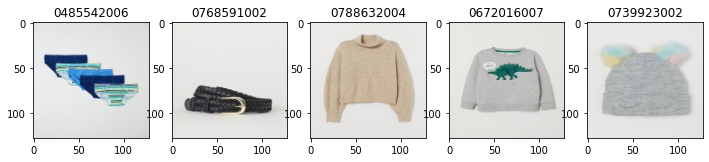





2 random article:
        91833    2-pack Kalyla shorts
Name: prod_name, dtype: object,
        91833    0851377001
Name: article_id, dtype: object,
        91833    Garment Lower body
Name: product_group_name, dtype: object
        


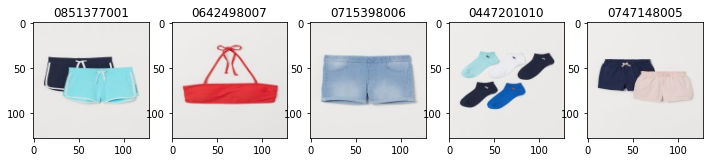





3 random article:
        85623    Tilda linen
Name: prod_name, dtype: object,
        85623    0820484007
Name: article_id, dtype: object,
        85623    Garment Upper body
Name: product_group_name, dtype: object
        


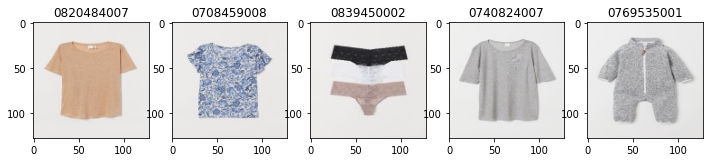





4 random article:
        101989    Special Occ Ana dress
Name: prod_name, dtype: object,
        101989    0901314001
Name: article_id, dtype: object,
        101989    Garment Full body
Name: product_group_name, dtype: object
        


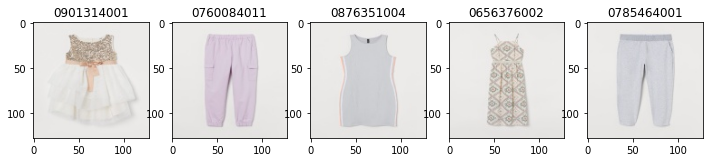





5 random article:
        75285    SB Olle
Name: prod_name, dtype: object,
        75285    0780612002
Name: article_id, dtype: object,
        75285    Garment Upper body
Name: product_group_name, dtype: object
        


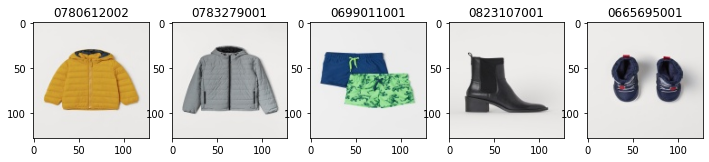

In [16]:
plot_n_random_similar_images(5, articles)

Garment Upper body
Random article id: 43138    0675489001
Name: article_id, dtype: object, random_article name: 43138    ES Soy cardigan
Name: prod_name, dtype: object


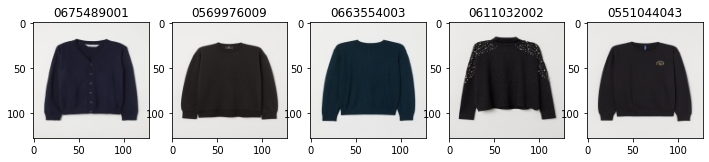





Underwear
Random article id: 20301    0588337001
Name: article_id, dtype: object, random_article name: 20301    Adriana nursing SPORT MID
Name: prod_name, dtype: object


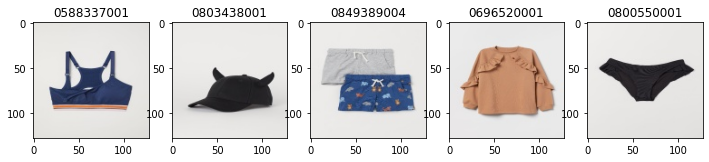





Socks & Tights
Random article id: 95112    0865481001
Name: article_id, dtype: object, random_article name: 95112    Lace edge 7pl shaftless BG
Name: prod_name, dtype: object


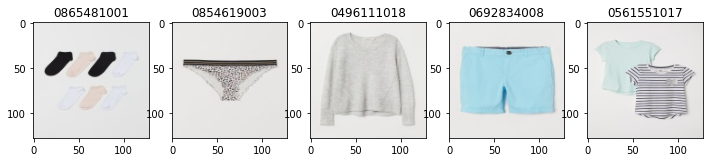





Garment Lower body
Random article id: 62785    0737358002
Name: article_id, dtype: object, random_article name: 62785    Molly Knee trash
Name: prod_name, dtype: object


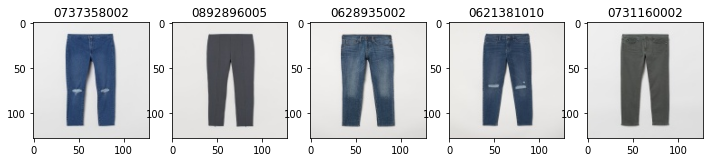





Accessories
Random article id: 3873    0468977003
Name: article_id, dtype: object, random_article name: 3873    Selena Shopper
Name: prod_name, dtype: object


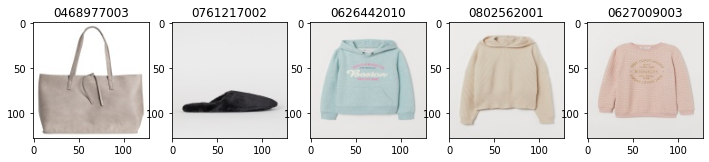





Items
Random article id: 102766    0906372001
Name: article_id, dtype: object, random_article name: 102766    Dog Wax Coat
Name: prod_name, dtype: object


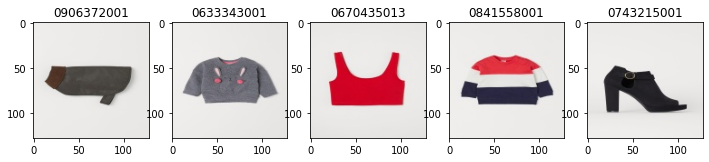





Nightwear
Random article id: 44142    0679135001
Name: article_id, dtype: object, random_article name: 44142    ES Eden onesie
Name: prod_name, dtype: object


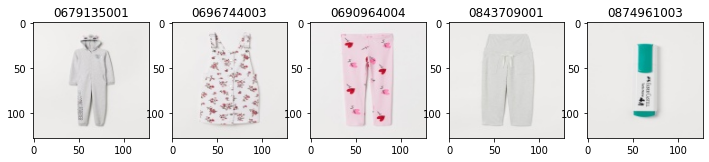





Unknown
Random article id: 37240    0653145007
Name: article_id, dtype: object, random_article name: 37240    &DENIM Skinny RW Chic(1)
Name: prod_name, dtype: object


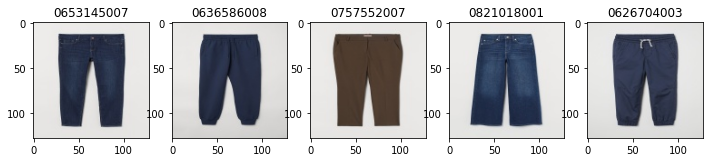





Underwear/nightwear
Random article id: 8603    0524454001
Name: article_id, dtype: object, random_article name: 8603    Thin sleeping bag
Name: prod_name, dtype: object


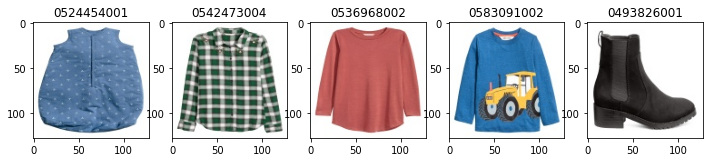





Shoes
Random article id: 81026    0804472003
Name: article_id, dtype: object, random_article name: 81026    Michael HT SB
Name: prod_name, dtype: object


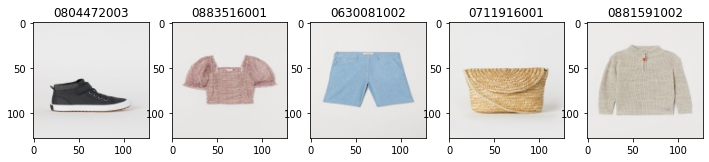





Swimwear
Random article id: 168    0188183018
Name: article_id, dtype: object, random_article name: 168    Spanx alot Swimsuit
Name: prod_name, dtype: object


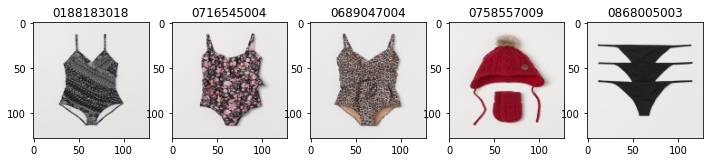





Garment Full body
Random article id: 76742    0786207002
Name: article_id, dtype: object, random_article name: 76742    Dress up Christmas set
Name: prod_name, dtype: object


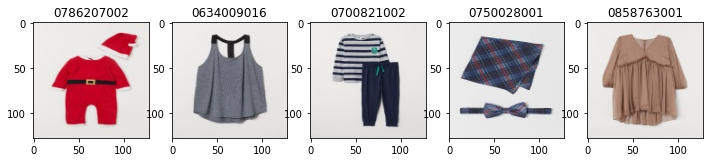





Cosmetic
Random article id: 64840    0743045001
Name: article_id, dtype: object, random_article name: 64840    Halloween Tattoos
Name: prod_name, dtype: object


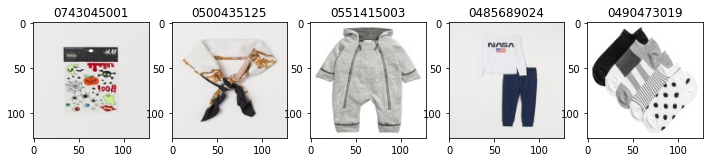





Interior textile
Random article id: 88239    0832168001
Name: article_id, dtype: object, random_article name: 88239    TOWEL cape(1)
Name: prod_name, dtype: object


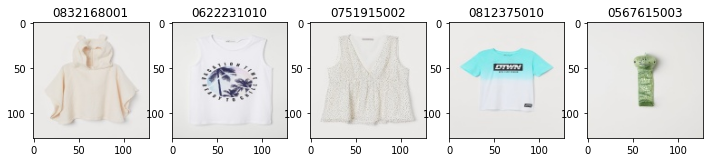





Bags
Random article id: 90958    0845714001
Name: article_id, dtype: object, random_article name: 90958    Bag Jimmy Sporty Weekend
Name: prod_name, dtype: object


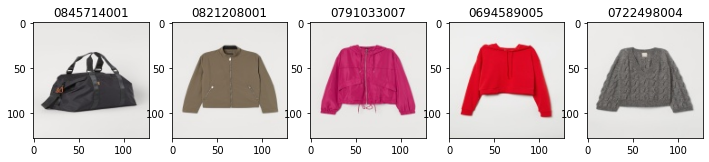





Furniture
Random article id: 62949    0738103001
Name: article_id, dtype: object, random_article name: 62949    TC DETERGENT BLACK (1)
Name: prod_name, dtype: object


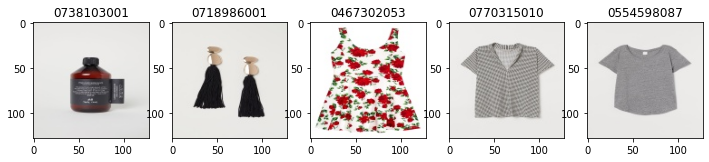





Garment and Shoe care
Random article id: 92079    0852390001
Name: article_id, dtype: object, random_article name: 92079    TC - ZIPPER METAL L
Name: prod_name, dtype: object


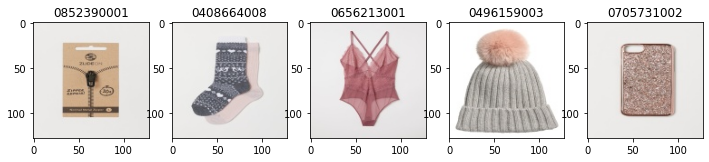





Fun
Random article id: 95767    0867904001
Name: article_id, dtype: object, random_article name: 95767    HLW MASK OWN
Name: prod_name, dtype: object


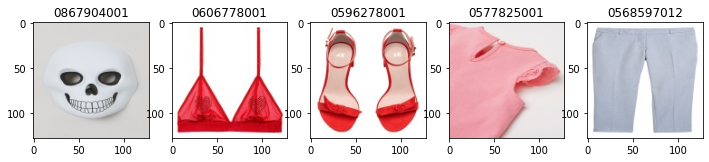





Stationery
Random article id: 97588    0874961003
Name: article_id, dtype: object, random_article name: 97588    TC - TEXTILE MARKER FC
Name: prod_name, dtype: object


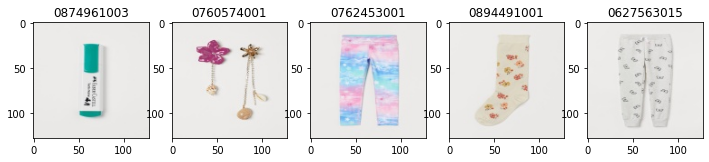

In [17]:
for product_group in articles.product_group_name.unique():
    print(product_group)
    random_article = articles[articles['product_group_name']==product_group].sample(1)
    print(f'Random article id: {random_article.article_id}, random_article name: {random_article.prod_name}')
    find_similar_images(random_article.article_id, embeddings, tree)
    print('\n\n\n')

### Tensorboard clustering

In [18]:
os.getcwd()

'/Users/mmadej/Desktop/Projects/gid-ml-framework/data/01_raw/images_128_128'

In [19]:
embeddings_sample = embeddings.sample(n=4_000)

In [20]:
all_images = embeddings_sample.index.to_list()

In [21]:
embeddings_sample.to_csv('../../../notebooks/tensorboard_embeddings/feature_vecs.tsv', sep="\t", index=False, header=False)

In [22]:
images_list = [Image.open(f'{article_id}.jpg').convert('RGB') for article_id in all_images]

In [23]:
image_width, image_height = images_list[0].size

In [24]:
image_width, image_height

(128, 128)

In [25]:
one_square_size = int(np.ceil(np.sqrt(len(images_list))))

In [26]:
master_width = image_width * one_square_size
master_height = image_height * one_square_size

In [27]:
master_width, master_height

(8192, 8192)

In [28]:
spriteimage = Image.new(
    mode='RGBA',
    size=(master_width, master_height),
    color=(0,0,0,0))  # fully transparent

In [29]:
for count, image in enumerate(images_list):
    div, mod = divmod(count, one_square_size)
    h_loc = image_width*div
    w_loc = image_width*mod
    spriteimage.paste(image, (w_loc, h_loc))

In [30]:
spriteimage.convert("RGB").save('../../../notebooks/tensorboard_embeddings/sprite.jpg', transparency=0)

In [31]:
all_images[:10]

['0803993006',
 '0733248001',
 '0696356009',
 '0652083001',
 '0305775031',
 '0883176001',
 '0293244001',
 '0716348004',
 '0903698002',
 '0738305003']

In [32]:
sample_articles = articles[articles.article_id.isin(all_images)].copy()

In [33]:
sample_articles.shape

(4000, 25)

In [34]:
sample_articles['article_id'] = pd.Categorical(sample_articles.article_id, categories=all_images, ordered=True)

In [35]:
sample_articles.sort_values(by='article_id', inplace=True)

In [36]:
sample_articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
80982,0803993006,803993,Dorsia dress(1),265,Dress,Garment Full body,1010016,Solid,73,Dark Blue,...,Dress,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1013,Dresses Ladies,"Knee-length, straight-cut dress in a softly dr..."
61448,0733248001,733248,Thelma dress,265,Dress,Garment Full body,1010016,Solid,13,Beige,...,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in pleated jersey with a r..."
50235,0696356009,696356,P-CAP OWN,69,Cap/peaked,Accessories,1010001,All over pattern,73,Dark Blue,...,Kids Boy Big Acc,J,"Children Accessories, Swimwear",4,Baby/Children,45,Kids Outerwear,1019,Accessories,Cap with a sweatband in a cotton weave and an ...
36918,0652083001,652083,PE Edda shirt 3,259,Shirt,Garment Upper body,1010017,Stripe,92,Green,...,Take Care External,A,Ladieswear,1,Ladieswear,97,Collaborations,1001,Unknown,"Shirt in mulberry silk with a collar, buttons ..."
955,0305775031,305775,Lurex tights SG,304,Underwear Tights,Socks & Tights,1010016,Solid,51,Light Pink,...,Kids Girl S&T,H,Children Sizes 92-140,4,Baby/Children,79,Girls Underwear & Basics,1021,Socks and Tights,Tights in a fine knit containing glittery thre...


In [37]:
sample_articles[['article_id', 'product_group_name', 'colour_group_name']].to_csv('../../../notebooks/tensorboard_embeddings/metadata.tsv', sep='\t', index=False)

In [38]:
# !cd to your folder with the files

In [39]:
# create a config in that folder
#embeddings {
#  tensor_path: "feature_vecs.tsv"
#  metadata_path: "metadata.tsv"
#  sprite {
#    image_path: "sprite.jpg"
#    single_image_dim: 50
#    single_image_dim: 50
#  }
#}

In [40]:
# !tensorboard --logdir .

In [41]:
# go to Projections -> select dimensionality reduction technique